# Machine Learning Trading Bot

In this Challenge, I’ll assume the role of a financial advisor. I will try to improve the existing algorithmic trading systems and maintain my firm’s competitive advantage in the market. 

The steps for this Challenge are divided into the following sections:

* Establish a Baseline Performance

* Tune the Baseline Trading Algorithm

* Evaluate a New Machine Learning Classifier

* Create an Evaluation Report

#### Establish a Baseline Performance

In this section, I’ll complete the following steps.

1. Import the OHLCV dataset into a Pandas DataFrame.

2. Generate trading signals using short- and long-window SMA values. 

3. Split the data into training and testing datasets.

4. Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

5. Review the classification report associated with the `SVC` model predictions. 

6. Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

7. Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

8. Write the conclusions about the performance of the baseline trading algorithm in the `README.md` file that’s associated with your GitHub repository. 

#### Tune the Baseline Trading Algorithm

In this section, I’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. (I’ll choose the best by comparing the cumulative products of the strategy returns.) To do so, I complete the following steps:

1. Tune the training algorithm by adjusting the size of the training dataset. To do so, slice the data into different periods. 

> **Hint** To adjust the size of the training dataset, you can use a different `DateOffset` value&mdash;for example, six months. Be aware that changing the size of the training dataset also affects the size of the testing dataset.

2. Tune the trading algorithm by adjusting the SMA input features. Adjust one or both of the windows for the algorithm. 

3. Choose the set of parameters that best improved the trading algorithm returns. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns.

#### Evaluate a New Machine Learning Classifier

In this section, I’ll complete the following steps:

1. Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

2. Using the original training data as the baseline model, fit another model with the new classifier.

3. Backtest the new model to evaluate its performance. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm.

#### Create an Evaluation Report

To accomplish this section, I added summary evaluation report at the end of the `README.md` file. In that report, I expressed my final conclusions and analysis. 


In [87]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

---

## Establishing a Baseline Performance


### Step 1: mport the OHLCV dataset into a Pandas DataFrame.

In [88]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("./Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [135]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


## Step 2: Generating trading signals using short- and long-window SMA values. 

In [90]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495


In [91]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0


In [92]:
signals_df['Signal'].value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [93]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0,0.000000
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0,0.000803
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0,0.000401
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0,0.001202


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


<AxesSubplot:xlabel='date'>

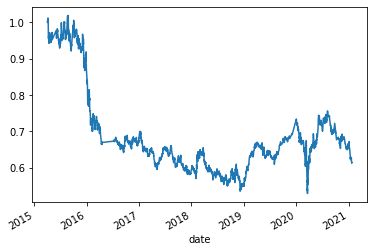

In [94]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

### Step 3: Splitting the data into training and testing datasets.

In [95]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [96]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [97]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 15:00:00


In [98]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2015-07-02 15:00:00


In [99]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [100]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [101]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [102]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model =svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [103]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.43      0.04      0.07      1804
         1.0       0.56      0.96      0.71      2288

    accuracy                           0.55      4092
   macro avg       0.49      0.50      0.39      4092
weighted avg       0.50      0.55      0.43      4092



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [104]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df["Actual Returns"] * predictions_df['Predicted']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,-0.003841
2015-07-07 11:30:00,1.0,-0.018423,-0.018423


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


In [106]:
signals_df["Actual Returns for the test data"] = signals_df["close"].loc['2015-12-03 10:30:00':].pct_change()
predictions_df['Strategy Returns_1']= signals_df["Actual Returns for the test data"] * predictions_df['Predicted']

In [109]:
signals_df['Original SVM Cumulative Returns']=(1 + predictions_df['Strategy Returns_1']).cumprod() - 1


In [110]:
signals_df["Actual Cumulative Returns for the test data"]= (1 + signals_df["Actual Returns for the test data"]).cumprod() - 1
signals_df

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns,Original SVM Cumulative Returns,Actual Returns for the test data,Actual Cumulative Returns for the test data
date,,,,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.32140,1.0,NaN,NaN,NaN,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.33080,1.0,0.000000,NaN,NaN,NaN
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.33600,1.0,0.000803,NaN,NaN,NaN
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.34110,1.0,0.000401,NaN,NaN,NaN
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.34630,1.0,0.001202,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866,0.752696,-0.006866,0.601830
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405,0.756911,0.002405,0.605681
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099,0.760598,0.002099,0.609052


### Step 7: Creating a cumulative return plot that shows the actual returns vs. the strategy returns. 
#### Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

<AxesSubplot:xlabel='date'>

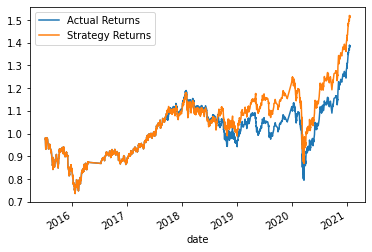

In [35]:
# Plot the actual returns versus the strategy returns
Baseline_plot_SVM=(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
Baseline_plot_SVM

In [36]:
Baseline_plot_SVM.get_figure().savefig("SVM_Baseline_plot.png", bbox_inches="tight")

---

## Tune the Baseline Trading Algorithm

## Step 6: Use an Alternative ML Model and Evaluate Strategy Returns

### Step 1: Tune the training algorithm by adjusting the size of the training dataset. 


In [111]:
#Tuning the training algorithm by feeding the first four month into training data
# Select the start of the training period
tuned_training_begin = X.index.min()

# Display the training begin date
print(tuned_training_begin)

2015-04-02 15:00:00


In [112]:
# Select the ending period for the training data with an offset of 4 months
tuned_training_end = X.index.min() + DateOffset(months=4)

# Display the training end date
print(tuned_training_end)

2015-08-02 15:00:00


In [113]:
# Generate the X_train and y_train DataFrames
X_train_tuned = X.loc[tuned_training_begin:tuned_training_end]
y_train_tuned = y.loc[tuned_training_begin:tuned_training_end]

In [114]:
# Generate the X_test and y_test DataFrames
X_test_tuned = X.loc[tuned_training_end+DateOffset(hours=1):]
y_test_tuned = y.loc[tuned_training_end+DateOffset(hours=1):]

In [115]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
tuned_X_scaler = scaler.fit(X_train_tuned)

# Transform the X_train and X_test DataFrames using the X_scaler
tuned_X_train_scaled = tuned_X_scaler.transform(X_train_tuned)
tuned_X_test_scaled = tuned_X_scaler.transform(X_test_tuned)

In [116]:
# From SVM, instantiate SVC classifier model instance
svm_model_tuned_training_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model_tuned_training_model =svm_model_tuned_training_model.fit(tuned_X_train_scaled, y_train_tuned)
 
# Use the testing data to make the model predictions
svm_pred_tuned_training_model = svm_model_tuned_training_model.predict(tuned_X_test_scaled)

# Review the model's predicted values
svm_pred_tuned_training_model[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [117]:
# Create a predictions DataFrame
predictions_tuned_training_df = pd.DataFrame(index=X_test_tuned.index)

# Add the SVM model predictions to the DataFrame
predictions_tuned_training_df['Predicted'] = svm_pred_tuned_training_model

# Add the actual returns to the DataFrame
predictions_tuned_training_df['Actual Returns'] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_tuned_training_df['Strategy Returns'] = predictions_tuned_training_df["Actual Returns"] * predictions_tuned_training_df['Predicted']

In [119]:
predictions_tuned_training_df['Strategy Returns_2']= signals_df["Actual Returns for the test data"] * predictions_tuned_training_df['Predicted']

In [120]:
signals_df['Cumulative Tuned training data with SVM']=(1 + predictions_tuned_training_df['Strategy Returns_2']).cumprod() - 1
signals_df

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns,Original SVM Cumulative Returns,Actual Returns for the test data,Actual Cumulative Returns for the test data,Cumulative Tuned training data with SVM
date,,,,,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.32140,1.0,NaN,NaN,NaN,NaN,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.33080,1.0,0.000000,NaN,NaN,NaN,NaN
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.33600,1.0,0.000803,NaN,NaN,NaN,NaN
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.34110,1.0,0.000401,NaN,NaN,NaN,NaN
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.34630,1.0,0.001202,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866,0.752696,-0.006866,0.601830,0.570557
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405,0.756911,0.002405,0.605681,0.574333
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099,0.760598,0.002099,0.609052,0.577638


In [153]:
columns = ['Total Cumulative Return']
metrics = [
    'Original SVM',
    'Original LR',
    'Tuned Training dataset',
    'Tuned Features',
    'Actual Return'] 

# Initialize the DataFrame with index set to the evaluation metrics and the column
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
portfolio_evaluation_df

,Total Cumulative Return
Original SVM,NaN
Original LR,NaN
Tuned Training dataset,NaN
Tuned Features,NaN
Actual Return,NaN


In [134]:
portfolio_evaluation_df.loc['Original SVM'] = signals_df['Original SVM Cumulative Returns'][-1]
portfolio_evaluation_df.loc['Actual Return'] = signals_df['Actual Cumulative Returns for the test data'][-1]
portfolio_evaluation_df.loc['Tuned Training dataset'] = signals_df['Cumulative Tuned training data with SVM'][-1]
portfolio_evaluation_df

,Total Cumulative Return
Original SVM,0.761652
Original LR,NaN
Tuned Training dataset,0.578582
Tuned Features,NaN
Actual Return,0.610014


<AxesSubplot:xlabel='date'>

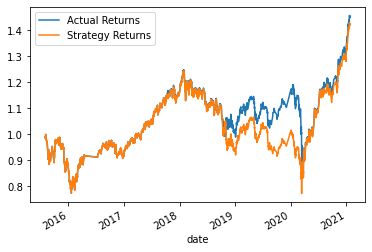

In [24]:
# Plot the actual returns versus the strategy returns
Tuned_training_plot_SVM=(1 + predictions_tuned_training_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
Tuned_training_plot_SVM

In [25]:
Tuned_training_plot_SVM.get_figure().savefig("SVM_Tuned_training_plot.png", bbox_inches="tight")

### Step 2: Tune the trading algorithm by adjusting the SMA input features. 


In [136]:
#Changing the time horizon for slow and fast SMA
# Set the short window and long window
short_window = 15
long_window = 90

# Generate the fast and slow simple moving averages (15 and 90 days, respectively)
signals_df['SMA_Fast_new'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow_new'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast_new,SMA_Slow_new
date,,,,
2015-04-02 12:15:00,24.90,0.000402,24.600000,24.255556
2015-04-02 12:30:00,24.91,0.000402,24.629333,24.265889
2015-04-02 12:45:00,24.91,0.000000,24.673333,24.271333
2015-04-02 13:00:00,24.92,0.000401,24.733333,24.276667
2015-04-02 13:15:00,24.91,-0.000401,24.792667,24.281667


,close,Actual Returns,SMA_Fast_new,SMA_Slow_new
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,32.819333,30.554944
2021-01-22 11:30:00,33.35,0.002405,32.877333,30.604722
2021-01-22 13:45:00,33.42,0.002099,32.942000,30.655389
2021-01-22 14:30:00,33.47,0.001496,32.994000,30.707167
2021-01-22 15:45:00,33.44,-0.000896,33.044667,30.758389


In [137]:
# Initialize the new Signal column
signals_df['Signal_new'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal_new'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal_new'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast_new,SMA_Slow_new,Signal_new
date,,,,,
2015-04-02 12:15:00,24.90,0.000402,24.600000,24.255556,1.0
2015-04-02 12:30:00,24.91,0.000402,24.629333,24.265889,1.0
2015-04-02 12:45:00,24.91,0.000000,24.673333,24.271333,1.0
2015-04-02 13:00:00,24.92,0.000401,24.733333,24.276667,1.0
2015-04-02 13:15:00,24.91,-0.000401,24.792667,24.281667,-1.0


,close,Actual Returns,SMA_Fast_new,SMA_Slow_new,Signal_new
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,32.819333,30.554944,-1.0
2021-01-22 11:30:00,33.35,0.002405,32.877333,30.604722,1.0
2021-01-22 13:45:00,33.42,0.002099,32.942000,30.655389,1.0
2021-01-22 14:30:00,33.47,0.001496,32.994000,30.707167,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.044667,30.758389,-1.0


In [138]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['New Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal_new'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast_new,SMA_Slow_new,Signal_new,New Strategy Returns
date,,,,,,
2015-04-02 12:15:00,24.90,0.000402,24.600000,24.255556,1.0,NaN
2015-04-02 12:30:00,24.91,0.000402,24.629333,24.265889,1.0,0.000402
2015-04-02 12:45:00,24.91,0.000000,24.673333,24.271333,1.0,0.000000
2015-04-02 13:00:00,24.92,0.000401,24.733333,24.276667,1.0,0.000401
2015-04-02 13:15:00,24.91,-0.000401,24.792667,24.281667,-1.0,-0.000401


,close,Actual Returns,SMA_Fast_new,SMA_Slow_new,Signal_new,New Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,32.819333,30.554944,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,32.877333,30.604722,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,32.942000,30.655389,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,32.994000,30.707167,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.044667,30.758389,-1.0,-0.000896


In [139]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast_new', 'SMA_Slow_new']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast_new,SMA_Slow_new
date,,
2015-04-02 12:30:00,24.600000,24.255556
2015-04-02 12:45:00,24.629333,24.265889
2015-04-02 13:00:00,24.673333,24.271333
2015-04-02 13:15:00,24.733333,24.276667
2015-04-02 13:30:00,24.792667,24.281667


In [140]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal_new']

In [141]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 12:30:00


In [142]:
# Select the ending period for the training data with an offset of 4 months
training_end = X.index.min() + DateOffset(months=4)

# Display the training end date
print(training_end)

2015-08-02 12:30:00


In [143]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast_new,SMA_Slow_new
date,,
2015-04-02 12:30:00,24.600000,24.255556
2015-04-02 12:45:00,24.629333,24.265889
2015-04-02 13:00:00,24.673333,24.271333
2015-04-02 13:15:00,24.733333,24.276667
2015-04-02 13:30:00,24.792667,24.281667


In [144]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

,SMA_Fast_new,SMA_Slow_new
date,,
2015-04-02 12:30:00,24.600000,24.255556
2015-04-02 12:45:00,24.629333,24.265889
2015-04-02 13:00:00,24.673333,24.271333
2015-04-02 13:15:00,24.733333,24.276667
2015-04-02 13:30:00,24.792667,24.281667


In [145]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [146]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model =svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [147]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted_new'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df["Actual Returns"] * predictions_df['Predicted_new']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted_new,Actual Returns,Strategy Returns
date,,,
2015-08-03 09:30:00,1.0,-0.013925,-0.013925
2015-08-03 10:15:00,1.0,-0.002648,-0.002648
2015-08-03 10:30:00,1.0,0.002212,0.002212
2015-08-03 10:45:00,1.0,0.000883,0.000883
2015-08-03 11:00:00,1.0,0.000441,0.000441


,Predicted_new,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


In [149]:
signals_df["Actual Returns for the test data"] = signals_df["close"].loc['2015-07-02 15:15:00':].pct_change()
signals_df['Cumulative Tuned features with SVM']=(1 + signals_df["Actual Returns for the test data"]).cumprod() - 1
signals_df

,close,Actual Returns,SMA_Fast_new,SMA_Slow_new,Signal_new,New Strategy Returns,Cumulative Tuned features with SVM,Actual Returns for the test data
date,,,,,,,,
2015-04-02 12:15:00,24.90,0.000402,24.600000,24.255556,1.0,NaN,NaN,NaN
2015-04-02 12:30:00,24.91,0.000402,24.629333,24.265889,1.0,0.000402,NaN,NaN
2015-04-02 12:45:00,24.91,0.000000,24.673333,24.271333,1.0,0.000000,NaN,NaN
2015-04-02 13:00:00,24.92,0.000401,24.733333,24.276667,1.0,0.000401,NaN,NaN
2015-04-02 13:15:00,24.91,-0.000401,24.792667,24.281667,-1.0,-0.000401,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-01-22 09:30:00,33.27,-0.006866,32.819333,30.554944,-1.0,-0.006866,0.378782,-0.006866
2021-01-22 11:30:00,33.35,0.002405,32.877333,30.604722,1.0,-0.002405,0.382097,0.002405
2021-01-22 13:45:00,33.42,0.002099,32.942000,30.655389,1.0,0.002099,0.384998,0.002099


In [150]:
portfolio_evaluation_df

,Total Cumulative Return
Original SVM,0.761652
Original LR,NaN
Tuned Training dataset,0.578582
Tuned Features,NaN
Actual Return,0.610014


In [152]:
portfolio_evaluation_df.loc['Tuned Features'] = signals_df['Cumulative Tuned features with SVM'][-1]
portfolio_evaluation_df

,Total Cumulative Return
Original SVM,0.761652
Original LR,NaN
Tuned Training dataset,0.578582
Tuned Features,0.385827
Actual Return,0.610014
Tuned features,0.385827


<AxesSubplot:xlabel='date'>

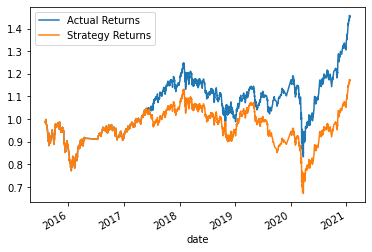

In [15]:
# Plot the actual returns versus the strategy returns
tuned_SMA_plot_SVM=(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
tuned_SMA_plot_SVM

In [16]:
tuned_SMA_plot_SVM.get_figure().savefig("tuned_SMA_plot_SVM.png", bbox_inches="tight")

### Step 3: Choosing the set of parameters that best improved the trading algorithm returns. 


I actually did that with different tunning techniques in previous sections.

---

## Evaluate a New Machine Learning Classifier


### Step 1:  Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

In [28]:
# Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression

# Initiate the model instance
model = LogisticRegression()

### Step 2: Using the original training data as the baseline model, fit another model with the new classifier.

In [29]:
# Fit the model using the training data
model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
pred = model.predict(X_test_scaled)

# Review the model's predicted values
pred


array([ 1.,  1.,  1., ..., -1., -1., -1.])

### Step 3: Backtest the new model to evaluate its performance. 


In [30]:
# Use a classification report to evaluate the model using the predictions and testing data
lr_test_report = classification_report(y_test, pred)


# Print the classification report
print (lr_test_report)


              precision    recall  f1-score   support

        -1.0       0.44      0.33      0.38      1804
         1.0       0.56      0.66      0.61      2288

    accuracy                           0.52      4092
   macro avg       0.50      0.50      0.49      4092
weighted avg       0.51      0.52      0.51      4092



In [33]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
lr_pred= pd.DataFrame(index=X_test.index)

# Add the Linear Regression model predictions to the DataFrame
lr_pred["predicted_signal"] = pred

# Add the actual returns to the DataFrame
lr_pred["actual_returns"] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
lr_pred["strategy_returns"] = lr_pred["predicted_signal"] * lr_pred["actual_returns"]

# Review the DataFrame
lr_pred.head()


,predicted_signal,actual_returns,strategy_returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,-0.003841
2015-07-07 11:30:00,1.0,-0.018423,-0.018423


<AxesSubplot:xlabel='date'>

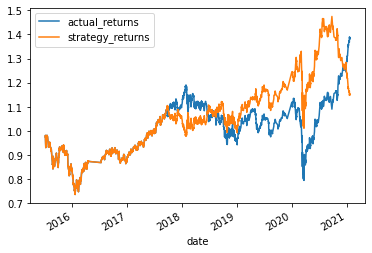

In [37]:
# Plot the actual returns versus the strategy returns
LR_Original_Parameters_Plot=(1 + lr_pred[["actual_returns", "strategy_returns"]]).cumprod().plot()
LR_Original_Parameters_Plot

In [38]:
LR_Original_Parameters_Plot.get_figure().savefig("LR_Original_Parameters_plot.png", bbox_inches="tight")